<a href="https://colab.research.google.com/github/Sara-Esm/rossmann-sales-forecasting/blob/main/Rossmann_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rossmann Store Sales Forecasting

## 🔍 Objective
Forecast daily sales for Rossmann stores using historical data, promotions, store metadata, and time-series features.

## 📦 Dataset Overview
- `train.csv`: Historical sales
- `store.csv`: Store-related metadata
- Source: [Kaggle Rossmann Sales Forecasting Competition](https://www.kaggle.com/competitions/rossmann-store-sales)

## 🔧 Tools & Techniques
- XGBoost Regressor
- Feature Engineering (Time, Promo, Competition, Lag)
- Log Transform + MAPE Evaluation


In [1]:
#1 Setup Kaggle API and Download Dataset

# Upload kaggle.json
from google.colab import files
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Rossmann dataset
!kaggle competitions download -c rossmann-store-sales --force

# Unzip
!unzip -o rossmann-store-sales.zip -d rossmann_data

Saving kaggle.json to kaggle.json
  0% 0.00/6.99M [00:00<?, ?B/s]
100% 6.99M/6.99M [00:00<00:00, 433MB/s]
Archive:  rossmann-store-sales.zip
  inflating: rossmann_data/sample_submission.csv  
  inflating: rossmann_data/store.csv  
  inflating: rossmann_data/test.csv  
  inflating: rossmann_data/train.csv  


In [12]:
#Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv("rossmann_data/train.csv", parse_dates=['Date'])
store = pd.read_csv("rossmann_data/store.csv")
df = train.merge(store, on='Store', how='left')

# Filter open stores and positive sales
df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

<ipython-input-12-424904741d9f>:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("rossmann_data/train.csv", parse_dates=['Date'])


In [14]:
#4 Feature Engineering

def add_features(df):
    # Date features
    df['Year'] = df['Date'].dt.year
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week

    # Competition features (with safer NaN handling)
    comp_open = (12*(df['Year']-df['CompetitionOpenSinceYear']) +
               (df['Date'].dt.month-df['CompetitionOpenSinceMonth']))
    df['MonthsSinceCompetition'] = comp_open.clip(lower=0)
    df['MonthsSinceCompetition'].fillna(0, inplace=True)  # If no competition

    # Promo features (fixed month parsing)
    month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

    def is_promo_month(row):
        if not isinstance(row['PromoInterval'], str) or row['PromoInterval'] == 'None':
            return 0
        months = [month_map[m.strip()] for m in row['PromoInterval'].split(',')
                 if m.strip() in month_map]
        return int(row['Date'].month in months)

    df['IsPromoMonth'] = df.apply(is_promo_month, axis=1)

    # Lag features (with groupby safety)
    df.sort_values(['Store','Date'], inplace=True)
    df['PrevWeekSales'] = df.groupby('Store')['Sales'].shift(7)
    df['PrevWeekSales'].fillna(0, inplace=True)  # For first weeks

    return df

df = add_features(df)

<ipython-input-14-67c0c75d337b>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthsSinceCompetition'].fillna(0, inplace=True)  # If no competition
<ipython-input-14-67c0c75d337b>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

🔥 Model Performance: 17.0% Mean Absolute Percentage Error


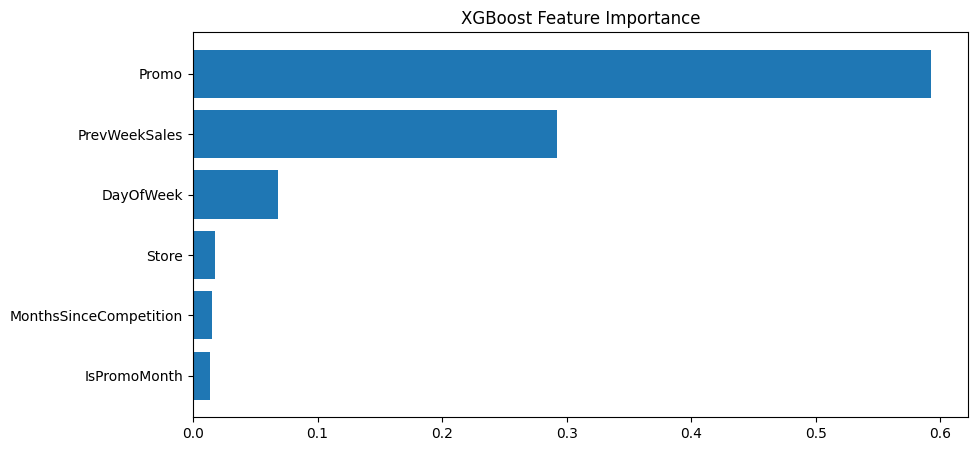

In [15]:
#3 Modeling & Evaluation

# Train/test split
X = df[['Store', 'DayOfWeek', 'Promo', 'MonthsSinceCompetition',
       'IsPromoMonth', 'PrevWeekSales']]
y = np.log1p(df['Sales'])  # Log transform for better performance

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Evaluate
predictions = np.expm1(model.predict(X_val))  # Convert back from log scale
mape = 100 * np.mean(np.abs(predictions - np.expm1(y_val))/np.expm1(y_val))

print(f"🔥 Model Performance: {mape:.1f}% Mean Absolute Percentage Error")

# Feature Importance
plt.figure(figsize=(10,5))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()